In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os

from model import *
from utils import *
# import torch.nn.functional as F

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def gradient(inp):
    D_dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    D_dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    return D_dx, D_dy

def sharpness(image):
    grad = gradient(image)
    mu = F.avg_pool2d(image, 7, 1, 7 // 2, count_include_pad=False) + 1e-8
    output = - (grad[0]**2 + grad[1]**2) - torch.abs((image - mu) / mu) - torch.pow(image - mu, 2)
    return -output

def smoothness(dpt, target):
    gt_grad = gradient(target)
    gt_grad_x_exp = torch.exp(-gt_grad[0].abs())
    gt_grad_y_exp = torch.exp(-gt_grad[1].abs())

    dx, dy = gradient(dpt.unsqueeze(1))
    dD_x = dx.abs() * gt_grad_x_exp
    dD_y = dy.abs() * gt_grad_y_exp
    sm_loss = (dD_x + dD_y).mean()

    return sm_loss.unsqueeze(0)

In [3]:
def gen_LoG_kernel(sigma, size):
    X = np.arange(size//2, -size//2, -1)
    Y = np.arange(size//2, -size//2, -1)
    xx, yy = np.meshgrid(X, Y)
    LoG_kernel = 1 / (np.pi * sigma ** 4) * (1 - (xx ** 2 + yy ** 2) / (2 * sigma ** 2)) * np.exp(- (xx ** 2 + yy ** 2) / (2 * sigma ** 2))    
    return torch.from_numpy(LoG_kernel).type(torch.float32).unsqueeze(0)

In [4]:
data_path = "/mnt/cfs/sihaozhe/data/fs_7_05"
device = 7
BS = 4
use_cuda = True

In [5]:
dataset_config = {
    'root_dir': data_path,
    'shuffle': False,
    'img_num': 5, 
    'visible_img': 5,
    'focus_dist': [0.1,.15,.3,0.7,1.5],
    'recon_all': True,
    'RGBFD': True,
    'DPT': True,
    'AIF': True
}

In [6]:
torch.cuda.set_device(device)

In [7]:
camera = ThinLenCamera()

In [8]:
render = GaussPSF(7)
render.cuda()

GaussPSF()

In [9]:
train_dl, test_dl = load_data(dataset_config, BS)

Total number of samples: 500
5 out of 5 images per sample are visible for input
Total number of training sample: 450


In [10]:
dl = iter(test_dl)

In [11]:
a = next(dl)

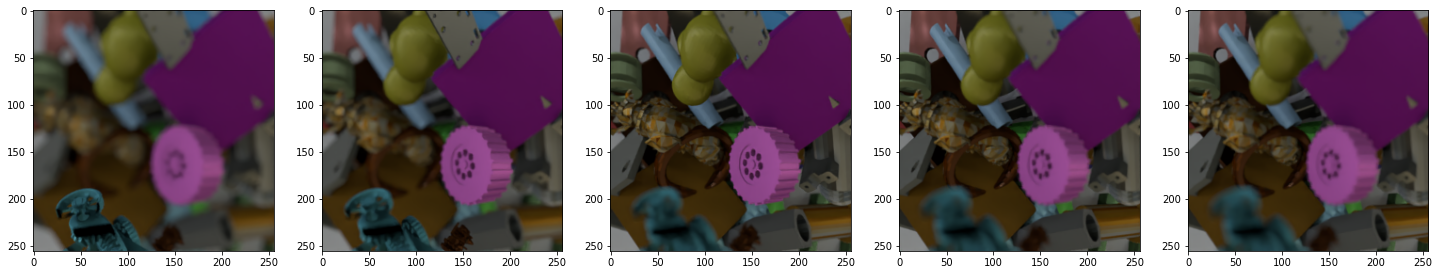

In [12]:
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(a['rgb_fd'].squeeze()[i].numpy().transpose(1, 2, 0)[:,:,:-1])

In [25]:
model_dict = torch.load(f'/mnt/cfs/sihaozhe/ss-dfd/exp/smooth_norm_rec1000.0_sharp100.0_sm10.0_blur0.1_E2000_B32_W16_D4_hard/model/final-model.pth')
state_dict = model_dict['model']
model = FUNet(4, 4)
model.load_state_dict(state_dict)
model = model.cuda()

In [26]:
a = next(dl)

In [27]:
op = model(a['rgb_fd'].cuda())#.detach().cpu()

In [28]:
torch.max(op[:,-1])

tensor(1.4552, device='cuda:7', grad_fn=<MaxBackward1>)

In [29]:
torch.min(a['dpt'])

tensor(0.1000)

In [30]:
np.mean(np.abs(np.clip(op.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)[:,:,-1], 0, 1) - a['dpt'].squeeze().numpy())**2)

0.03193274

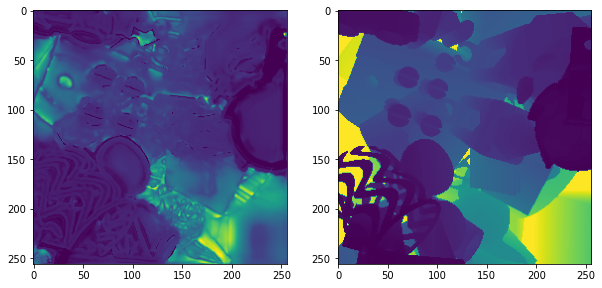

In [37]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.clip((op/1.4).squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)[:,:,-1], 0, 1))
plt.subplot(1, 2, 2)
plt.imshow(a['dpt'].squeeze().numpy())

In [32]:
H = 256
W = 256
# aif = op[:, :-1].unsqueeze(1).expand(1, 5, 3, H, W).contiguous().view(5, 3, H, W)
aif = a['aif'].unsqueeze(1).expand(1, 5, 3, H, W).contiguous().view(5, 3, H, W).cuda()
dpt = torch.clip(op[:,-1], 0, 1).expand(5, 256, 256).contiguous().cuda()
fd = a['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd.cuda())
recon = render(aif, defocus)

In [33]:
dpt.shape

torch.Size([5, 256, 256])

In [34]:
torch.mean(dpt[0])

tensor(0.2726, device='cuda:7', grad_fn=<MeanBackward0>)

In [35]:
a['output'].shape

torch.Size([1, 5, 3, 256, 256])

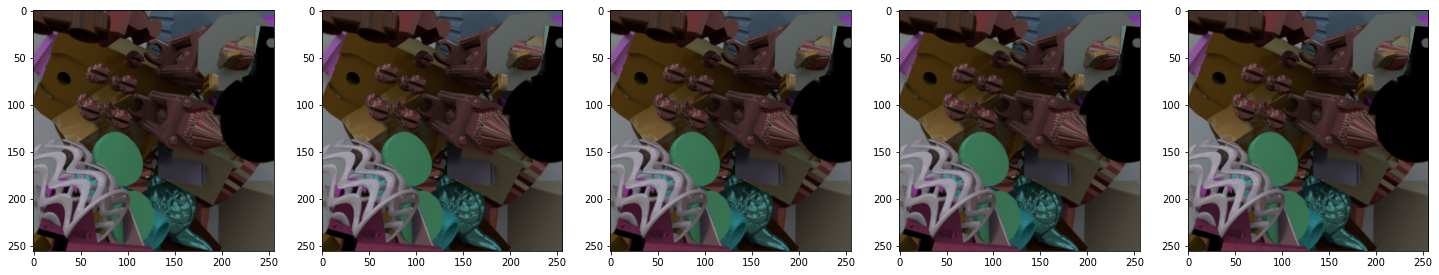

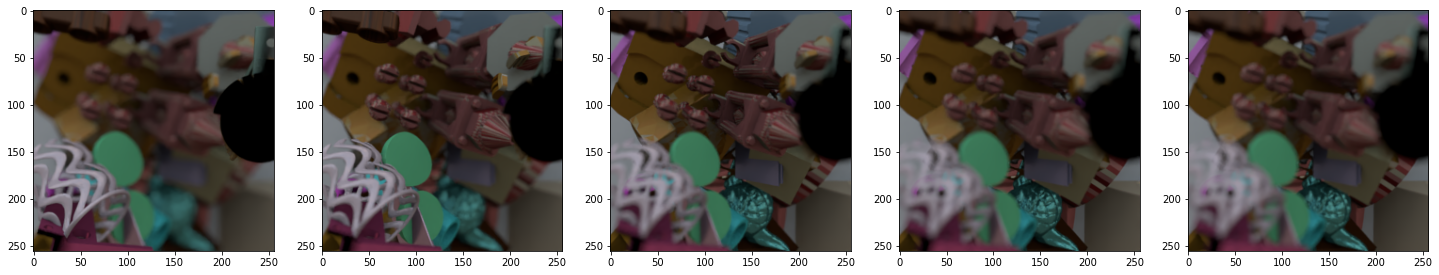

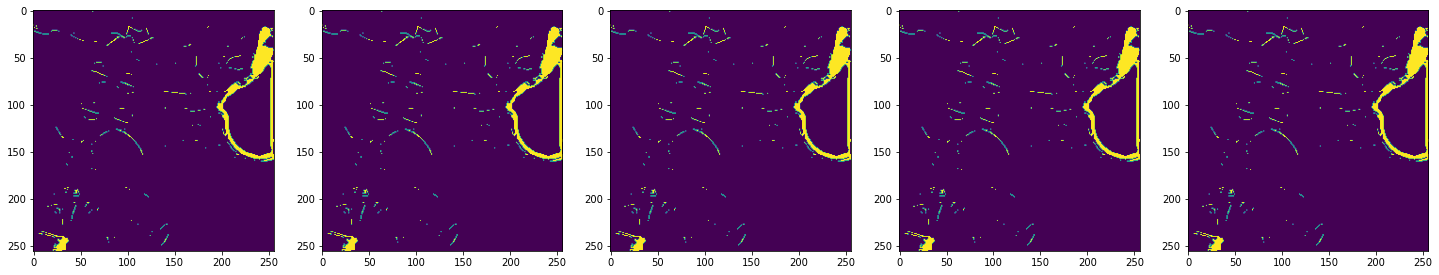

In [36]:
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(recon[i].detach().cpu().numpy().transpose(1, 2, 0))
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(a['rgb_fd'].squeeze()[i].numpy().transpose(1, 2, 0)[:,:,:-1])
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i].detach().cpu().numpy())

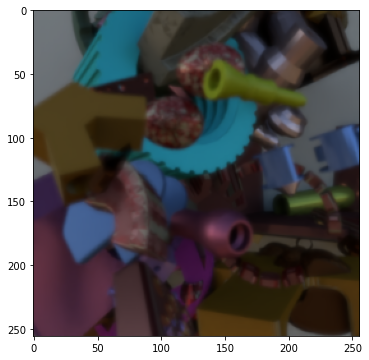

In [98]:
mean_fs = torch.mean(a['rgb_fd'], dim=1)[0, :-1].numpy().transpose(1, 2, 0)
plt.figure(figsize=(6, 6))
plt.imshow(mean_fs)

In [25]:
def gaussian_kernel(size=5, channels=3, sigma=1):
    gaussian_array = [[1/np.sqrt(2*np.pi*sigma**2)*np.exp(-i**2/(2*sigma**2)) for i in range(size//2, -size//2, -1)]]
    kernel = np.outer(gaussian_array, gaussian_array)
    kernel /= np.sum(kernel)
    # Change kernel to PyTorch. reshapes to (channels, 1, size, size)
    kernel_tensor = torch.as_tensor(kernel, dtype=torch.float)
    kernel_tensor = kernel_tensor.repeat(channels, 1 , 1, 1)
    return kernel_tensor

def gaussian_conv2d(x, g_kernel):
    #Assumes input of x is of shape: (minibatch, depth, height, width)
    #Infer depth automatically based on the shape
    channels = g_kernel.shape[0]
    padding = g_kernel.shape[-1] // 2 # Kernel size needs to be odd number
    if len(x.shape) != 4:
        raise IndexError('Expected input tensor to be of shape: (N, C, H, W) but got: ' + str(x.shape))
    y = F.conv2d(x, weight=g_kernel, stride=1, padding=padding, groups=channels)
    return y

def downsample(x):
    # Downsamples along  image (H,W). Takes every 2 pixels. output (H, W) = input (H/2, W/2)
    return x[:, :, ::2, ::2]

def create_laplacian_pyramid(x, kernel, levels, expand=True):
    if expand:
        upsample = torch.nn.Upsample(scale_factor=2) # Default mode is nearest: [[1 2],[3 4]] -> [[1 1 2 2],[3 3 4 4]]
    pyramids = []
    current_x = x
    for level in range(levels):
        gauss_filtered_x = gaussian_conv2d(current_x, kernel)
        if expand:
            down = downsample(gauss_filtered_x)
            laplacian = current_x - upsample(down) 
            current_x = down 
        else:
            laplacian = current_x - gauss_filtered_x
            current_x = gauss_filtered_x
        pyramids.append(laplacian)
    pyramids.append(current_x)
    return pyramids

In [26]:
kernel = gaussian_kernel(size=5, channels=3, sigma=1)

In [27]:
op_pyramid = create_laplacian_pyramid(a['output'][0], kernel, 4)

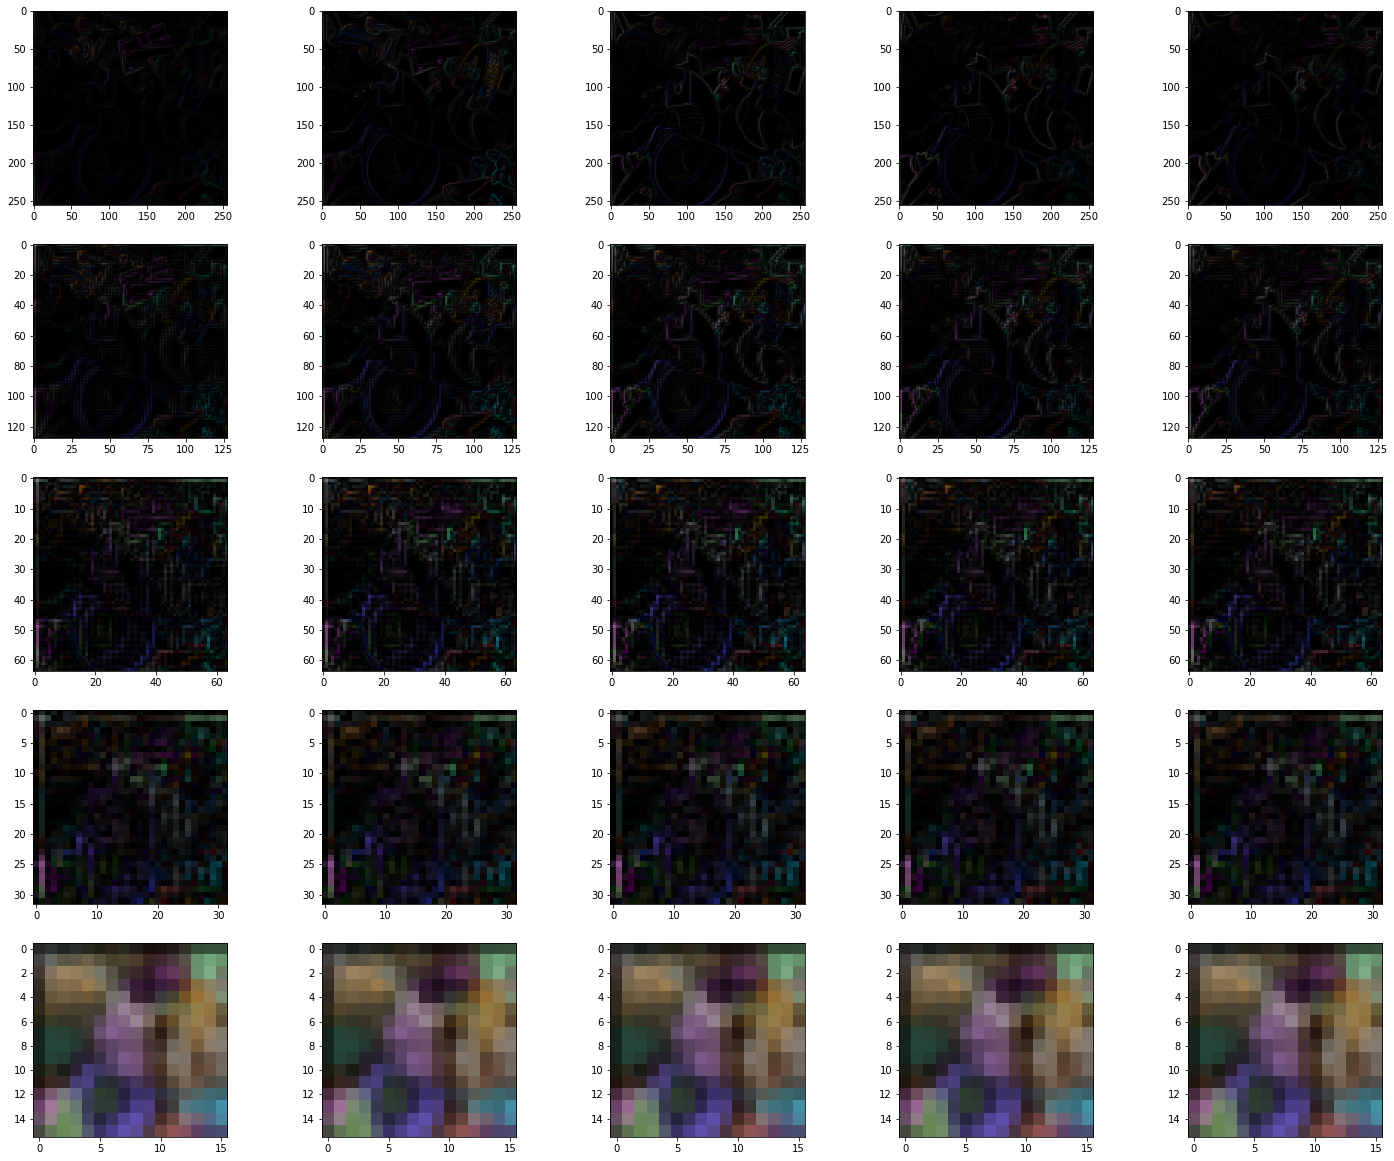

In [28]:
plt.figure(figsize=(25, 25))
for i in range(5):
    for j in range(5):
        plt.subplot(6, 5, j + 1 + 5 * i)    
        plt.imshow(np.abs(op_pyramid[i][j].numpy().transpose(1, 2, 0)))

In [29]:
recon_sharp = sharpness(recon[4].unsqueeze(0))
gt_sharp = sharpness(a['output'][0,None, 4])
aif_sharp = sharpness(a['aif'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


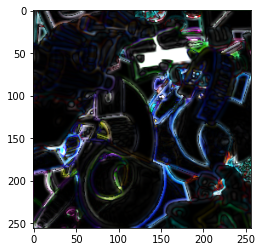

In [30]:
plt.imshow(recon_sharp[0].detach().cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


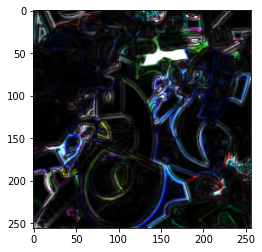

In [31]:
plt.imshow(gt_sharp[0].detach().cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


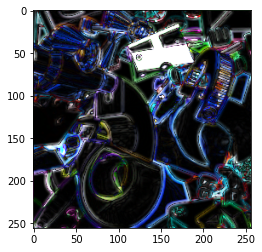

In [32]:
plt.imshow(aif_sharp[0].detach().cpu().numpy().transpose(1, 2, 0))

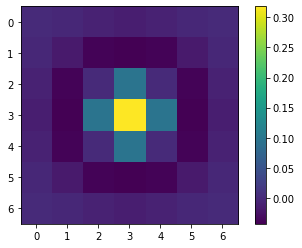

In [33]:
size = 7
sigma = 1
LoG_kernel = gen_LoG_kernel(sigma, size)
plt.imshow(LoG_kernel.squeeze(0))
plt.colorbar()

In [34]:
Laif = F.conv2d(torch.mean(a['aif'], dim=1).unsqueeze(1), LoG_kernel.unsqueeze(0), padding='same')

In [35]:
Laif.shape

torch.Size([1, 1, 256, 256])

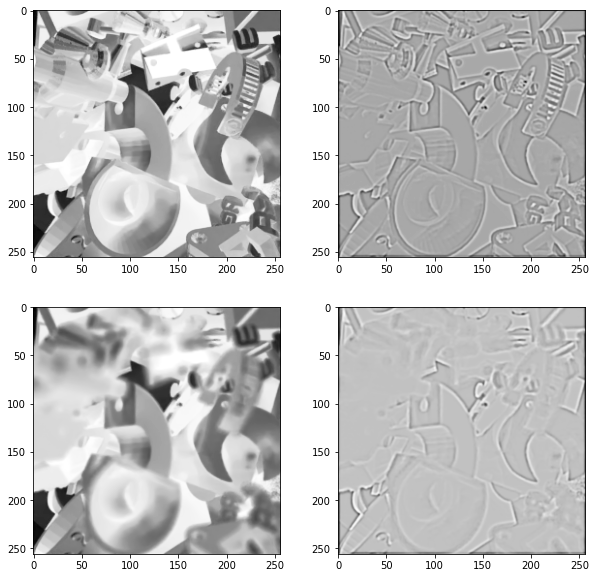

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
g_aif = torch.mean(a['aif'][0], dim=0)
plt.imshow(g_aif, cmap='Greys')
plt.subplot(2, 2, 2)
Laif = F.conv2d(torch.mean(a['aif'], dim=1).unsqueeze(1), LoG_kernel.unsqueeze(0), padding='same')
plt.imshow(Laif.squeeze(), cmap='Greys')
plt.subplot(2, 2, 3)
g_defoc = torch.mean(a['output'][0, -1], dim=0)
plt.imshow(g_defoc, cmap='Greys')
plt.subplot(2, 2, 4)
Ldefoc = F.conv2d(torch.mean(a['output'][:, -1], dim=1).unsqueeze(0), LoG_kernel.unsqueeze(0), padding='same')
plt.imshow(Ldefoc.squeeze(), cmap='Greys')

In [37]:
for i in range(5):
    g_defoc = torch.mean(a['output'][0, i], dim=0)
    Ldefoc = F.conv2d(torch.mean(a['output'][:, i], dim=1).unsqueeze(0), LoG_kernel.unsqueeze(0), padding='same')
    blur_loss = -torch.log(torch.sum(Ldefoc**2) / (256*256 - torch.mean(g_defoc)))
    print(blur_loss)

tensor(7.4757)
tensor(6.9558)
tensor(6.8089)
tensor(6.9436)
tensor(7.0916)


In [38]:
gt_defocus = camera.getCoC(a['dpt'], fd).squeeze()
defocus = camera.getCoC(dpt, fd.cuda()).squeeze()

In [39]:
indices = torch.argmin(defocus, dim=0, keepdim=True).unsqueeze(0).expand(1, 1, 256, 256)

In [40]:
min_idx = torch.min(gt_defocus, dim=0, keepdim=True)[1]
inf_min_idx = torch.min(defocus, dim=0, keepdim=True)[1]

In [41]:
grey_fs = torch.mean(a['output'], dim = -3)

In [42]:
grey_fs.shape

torch.Size([1, 5, 256, 256])

In [43]:
a['rgb_fd'].shape

torch.Size([1, 5, 4, 256, 256])

In [44]:
min_idx.view(-1)

tensor([3, 3, 3,  ..., 1, 1, 1])

In [45]:
defocs.view(5, -1)[:, min_idx].shape

NameError: name 'defocs' is not defined

In [ ]:
coarse_aif = torch.gather(grey_fs.cuda(), 1, indices.cuda())

In [ ]:
coarse_aif.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
g_aif = torch.mean(a['aif'][0], dim=0)
plt.imshow(g_aif, cmap='Greys')
plt.subplot(2, 2, 2)
Laif = F.conv2d(torch.mean(a['aif'], dim=1).unsqueeze(1), LoG_kernel.unsqueeze(0), padding='same')
plt.imshow(Laif.squeeze(), cmap='Greys')
plt.subplot(2, 2, 3)
plt.imshow(coarse_aif.squeeze().cpu(), cmap='Greys')
plt.subplot(2, 2, 4)
Lcaif = F.conv2d(coarse_aif.cuda(), LoG_kernel.unsqueeze(0).cuda(), padding='same')
plt.imshow(Lcaif.squeeze().cpu(), cmap='Greys')

In [ ]:
-torch.log(torch.sum(Lcaif**2) / (256*256 - torch.mean(coarse_aif)))

In [ ]:
Lcaif = F.conv2d(coarse_aif, LoG_kernel.unsqueeze(0).cuda(), padding='same')
Lcaiff = Lcaif**2

In [ ]:
(-torch.log(torch.sum(Lcaiff, dim=[1,2,3])/(256*256 - torch.mean(coarse_aif, dim=[1,2,3])**2))).mean()

In [ ]:
torch.mean(coarse_aif, dim=[1,2,3])

In [ ]:
l1 = nn.L1Loss()
l1(coarse_aif,coarse_aif)

In [ ]:
blur = BlurMetric('blur')

In [ ]:
dpt = a['dpt'].expand(B, FS, H, W).contiguous().view(B*FS, H, W)
fd = a['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd)

In [ ]:
B, FS, C, H, W = a['output'].shape
grey_fs = torch.mean(a['rgb_fd'][:, :, :-1], dim=-3)
# clear_idx = torch.argmin(defocus.view(B, FS, H, W), dim=1, keepdim=True)
clear_w = F.softmin(defocus.view(B, FS, H, W), dim=1)
coarse_aif = torch.sum(grey_fs * clear_w, dim=1, keepdim=True)

In [ ]:
coarse_aif.shape

In [ ]:
defocus.shape

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(coarse_aif[i, 0], cmap='Greys')

In [ ]:
blur(coarse_aif.cuda())

In [ ]:
clear_idx[0]

In [ ]:
F.softmin(defocus.view(B, FS, H, W), dim=1)[0,:,0, 0]

In [2]:
data_path = "/mnt/cfs/sihaozhe/data/NYUv2"
dataset_config = {
    'root_dir': data_path,
    'shuffle': True,
    'img_num': 100, 
    'visible_img': 5,
    'focus_dist': np.linspace(1, 9, 100),
    'recon_all': True,
    'RGBFD': True,
    'DPT': True,
    'AIF': True,
    'scale': 1,
    'near': 0.1,
    'far': 10.,
}

In [11]:
train, test, val = load_data(dataset_config, 'NYU100', 4)

5 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


In [10]:
dataset_valid = NYUFS100Dataset(**dataset_config, split='test')